![nsdf](https://www.sci.utah.edu/~pascucci/public/NSDF-large.png)  
[National Science Data Fabric](https://nationalsciencedatafabric.org/) 

# Converting Nexus data 

NOTES:
- `1420*1420 *310*float32` Each timestep is **2 GiB**
- 
Original example:

```
root:NXroot
  @HDF5_Version = '1.12.1'
  @file_name = '/nfs/chess/id4baux/2022-3/clancy-3316-a/CaYIrO...'
  @file_time = '2022-12-14T22:23:39.738282'
  @h5py_version = '3.7.0'
  @nexusformat_version = '0.7.6'
  entry:NXentry
    data:NXdata
      @axes = ['H', 'K', 'L']
      @signal = 'counts'
      H = float32(1420)
        @long_name = 'H'
      K = float32(1420)
        @long_name = 'K'
      L = float32(310)
        @long_name = 'L'
      counts = float32(1420x1420x310)
        @long_name = 'counts'
```

Streamable example:
- NOTE the @streamable attribute at the root level
- NOTE the @openvisus  attribute inside the NXfield
```
root:NXroot
  @HDF5_Version = '1.12.2'
  @file_name = 'C:\visus_datasets\3scans_HKLI.streamable.nxs'
  @file_time = '2023-09-05T15:10:10.784258'
  @h5py_version = '3.9.0'
  @nexusformat_version = '1.0.2'
  @streamable = True
  entry:NXentry
    data:NXdata
      @axes = ['H', 'K', 'L']
      @signal = 'counts'
      H = float32(1420)
        @long_name = 'H'
      K = float32(1420)
        @long_name = 'K'
      L = float32(310)
        @long_name = 'L'
      counts = float32(1420x1420x310)
        @openvisus = '['C:/visus_datasets/3scans_HKLI.counts.idx']'
```

In [18]:
import os ,sys, time, logging,shutil,copy
from datetime import datetime
import numpy as np

# import nexus
# python3 -m pip install nexusformat
# https://github.com/nexpy/nexusformat/blob/main/src/nexusformat/nexus/tree.py

from nexusformat.nexus import * 
from nexusformat.nexus.tree import NX_CONFIG 
NX_CONFIG['memory']=16000 # alllow data to be 16000MB (i.e. 16GB)

# import openvisus
if os.path.isdir(r"C:\projects\OpenVisus\build\RelWithDebInfo"):
	sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")

import OpenVisus as ov
os.environ["VISUS_DISABLE_WRITE_LOCK"]="1"
logger= logging.getLogger("OpenVisus")
if False: ov.SetupLogger(logger, output_stdout=True) # for debugging

# /////////////////////////////////////////////////////////////////////////
def NexusTraverse(cur,nrec=0):
	yield (nrec,cur)
	for _k, child in (cur.entries.items() if hasattr(cur,"entries") else []): 
		yield from NexusTraverse(child,nrec+1)

# /////////////////////////////////////////////////////////////////////////
def NexusPrint(cur):
	for depth, node in NexusTraverse(cur):
		extra=f" shape={node.shape} dtype={node.dtype}" if isinstance(node,NXfield) else ""
		print("  "*(depth+0), f"{node.nxname}::{type(node)} {extra}")
		for k,v in node.attrs.items():
			print("  "*(depth+1),f"@{k} = {v}")

# ////////////////////////////////////////////////////////////
class NexusCreateStreamable:

	# TODO: what is the criteria to remove fields?
	MAX_NXFIELD_BYTES=1024*1024

	# constructor
	def __init__(self,src_filename, dst_filename, idx_filename_template):
		self.src_filename=src_filename
		self.dst_filename=dst_filename
		self.idx_filename_template=idx_filename_template

	# run
	def run(self):
		print(f"NexusCreateStreamable::run filename={self.src_filename} full-size={os.path.getsize(self.src_filename):,}")
		if os.path.isfile(self.dst_filename): os.remove(self.dst_filename)
		src=nxload(self.src_filename)
		dst=copy.deepcopy(src)
		dst.attrs["streamable"]=True
		self._convertNexusFieldsToOpenVisus(src, dst)
		nxsave(self.dst_filename, dst , mode='w')
		print(f"NexusCreateStreamable::run filename={self.dst_filename} reduced-size={os.path.getsize(self.dst_filename):,}")
		return dst
	
	# _convertNexusFieldsToOpenVisus
	def _convertNexusFieldsToOpenVisus(self, src, dst):

		if isinstance(src,NXfield):

			if src.nbytes<=self.MAX_NXFIELD_BYTES:

				# deepcopy does not seem to copy nxdata (maybe for the lazy evalation?)
				dst.nxdata=copy.copy(src.nxdata)

			else:

				print("Removing Nxfield",src.nxname)

				# replace any 'big' field with something virtually empty
				# TODO: read nexus by slabs
				t1=time.time()
				print(f"Reading Nexus field {src.nxname}...")
				data = src.nxdata
				print(f"Read Nexus field  in {time.time()-t1} seconds")

				# this is the version without any data
				new_field=NXfield(value=None, shape=src.shape, dtype=data.dtype)

				idx_filename=self.idx_filename_template.replace("{NxField::nxname}",src.nxname)

				t1=time.time()
				print(f"Creating IDX file {idx_filename}...")
				field=ov.Field.fromString(f"""DATA {str(data.dtype)} format(row_major) min({np.min(data)}) max({np.max(data)})""")
				db=ov.CreateIdx(url=idx_filename, dims=list(reversed(data.shape)), fields=[field], compression="raw")
				db.write(data)
				print(f"Created IDX file {idx_filename} in {time.time()-t1} seconds")

				# add as attribute (list of openvisus files)
				new_field.attrs["openvisus"]=repr([idx_filename])

				# need to modify the parent
				dst.nxgroup[src.nxname]=new_field
		
		# recurse
		if hasattr(src,"items"):
			for name in src.entries:
					src_child=src.entries[name]
					dst_child=dst.entries[name]
					self._convertNexusFieldsToOpenVisus(src_child, dst_child)


print(time.time(),"all Nexus utils defined")

1694068728.935148 all Nexus utils defined


# Create Streamable 

In [10]:
t1=time.time()
streamable=NexusCreateStreamable(
	"C:/visus_datasets/3scans_HKLI.nxs", 
	"C:/visus_datasets/3scans_HKLI.streamable.nxs", 
	"C:/visus_datasets/3scans_HKLI.{NxField::nxname}.idx").run()
print(f"Created streamable in {time.time()-t1} seconds")

NexusCreateStreamable::run filename=C:/visus_datasets/3scans_HKLI.nxs full-size=1,184,498,405
Removing Nxfield counts
Reading Nexus field counts...
Read Nexus field  in 8.819734573364258 seconds
Creating IDX file C:/visus_datasets/3scans_HKLI.counts.idx...
Created IDX file C:/visus_datasets/3scans_HKLI.counts.idx in 4.477014541625977 seconds
NexusCreateStreamable::run filename=C:/visus_datasets/3scans_HKLI.streamable.nxs reduced-size=22,760
Created streamable in 13.325733423233032 seconds


In [20]:
print(streamable.tree)
print("---"*10)
NexusPrint(streamable)

root:NXroot
  @HDF5_Version = '1.12.2'
  @file_name = 'C:\visus_datasets\3scans_HKLI.streamable.nxs'
  @file_time = '2023-09-07T08:36:14.400345'
  @h5py_version = '3.9.0'
  @nexusformat_version = '1.0.2'
  @streamable = True
  entry:NXentry
    data:NXdata
      @axes = ['H', 'K', 'L']
      @signal = 'counts'
      H = float32(1420)
        @long_name = 'H'
      K = float32(1420)
        @long_name = 'K'
      L = float32(310)
        @long_name = 'L'
      counts = float32(1420x1420x310)
        @openvisus = '['C:/visus_datasets/3scans_HKLI.counts.idx']'
------------------------------
 root::<class 'nexusformat.nexus.tree.NXroot'> 
   @HDF5_Version = 1.12.2
   @file_name = C:\visus_datasets\3scans_HKLI.streamable.nxs
   @file_time = 2023-09-07T08:36:14.400345
   @h5py_version = 3.9.0
   @nexusformat_version = 1.0.2
   @streamable = True
   entry::<class 'nexusformat.nexus.tree.NXentry'> 
     data::<class 'nexusformat.nexus.tree.NXdata'> 
       @axes = ['H', 'K', 'L']
       @signa

# NEXUS plot

Notes:
- using the **streamable version** as much as I can to show they are equivalent

In [21]:
# find an item with axes and signal as childs
# note: nxdata is the entry in the nexus tree containing axes and signal
nxdata=[node for depth, node in NexusTraverse(streamable) if isinstance(node,NXdata) and "axes" in node.attrs and "signal" in node.attrs][0]
 
axis=[nxdata[it] for it in nxdata.attrs["axes"]]
assert(all([isinstance(it,NXfield) for it in axis]))
H,K,L=axis

signal=nxdata[nxdata.attrs["signal"]]
assert(isinstance(signal,NXfield))

print(f"Nexus load done in {time.time()-t1} seconds dtype={signal.dtype} shape={signal.shape}")

project=[
	(0,1,2), 
	(1,0,2), 
	(2,0,1)
]

# ranges are in 'physical coordinates'
ranges=[(axis[I].nxdata[0], axis[I].nxdata[-1]) for I in range(3)]
print(ranges)

D,H,W=signal.shape
Y1,Y2,MY= 0, D, D//2
Z1,Z2,MZ= 0, H, H//2
X1,X2,MX= 0, W, W//2

Nexus load done in 247.1755130290985 seconds dtype=float32 shape=(1420, 1420, 310)
[(-7.1, 7.09), (-7.1, 7.09), (-3.1, 3.08)]


# Example of plot with proper names/limits

Loaded original in 0.008002996444702148 seconds
root:NXroot
  @HDF5_Version = '1.12.1'
  @file_name = '/nfs/chess/id4baux/2022-3/clancy-3316-a/CaYIrO...'
  @file_time = '2022-12-14T22:23:39.738282'
  @h5py_version = '3.7.0'
  @nexusformat_version = '0.7.6'
  entry:NXentry
    data:NXdata
      @axes = ['H', 'K', 'L']
      @signal = 'counts'
      H = float32(1420)
        @long_name = 'H'
      K = float32(1420)
        @long_name = 'K'
      L = float32(310)
        @long_name = 'L'
      counts = float32(1420x1420x310)
        @long_name = 'counts'


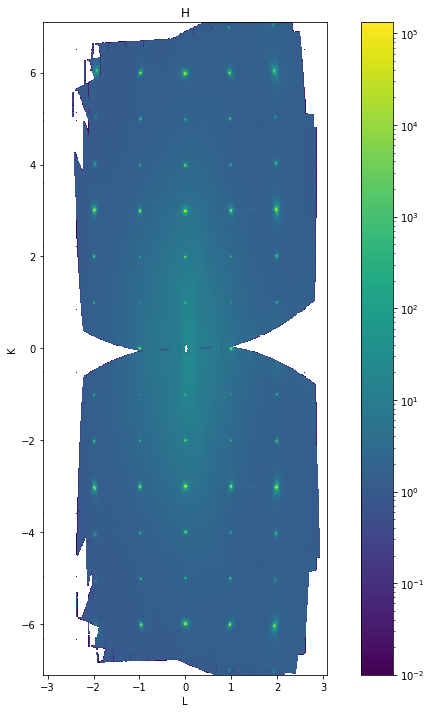

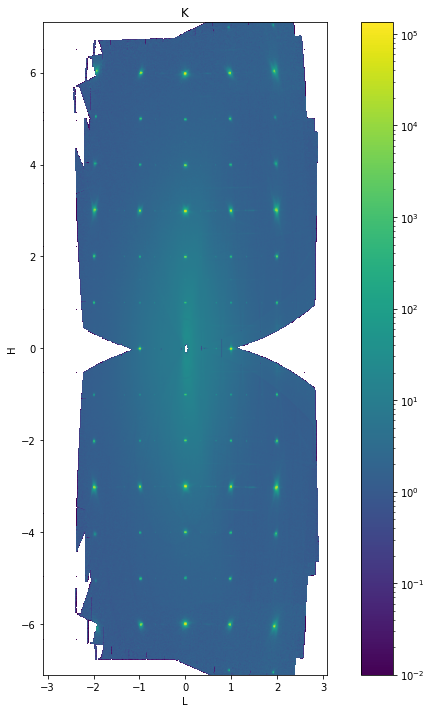

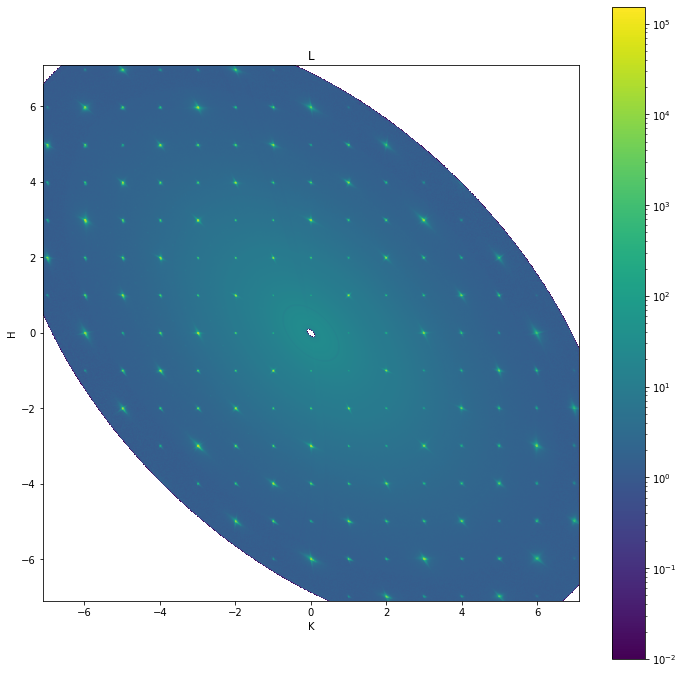

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# ///////////////////////////////////////////////////////////////////
def ShowSlice(A, img,figsize=(12, 12), cmap="viridis", log=True):

	axis_name=axis[A].nxname
	Z,Y,X=project[A]

	fig, ax = plt.subplots(figsize=figsize)
	ax.set_title(axis_name)
	
	y1,y2=ranges[Y];ax.set_ylabel(axis[Y].nxname)
	x1,x2=ranges[X];ax.set_xlabel(axis[X].nxname)
	
	# todo other cases
	assert(log) 
	vmin = np.nanmin(img[img > -np.inf])
	vmax = np.nanmax(img[img <  np.inf])
	
	norm=colors.LogNorm(max(vmin, 0.01), max(vmax, 0.01))
	pos=ax.imshow(np.flip(img,axis=0),origin="upper", norm=norm, cmap=cmap,  extent=[x1,x2,y1,y2])

	ax.set_aspect('equal')
	ax.set_xlim(x1,x2)
	ax.set_ylim(y1,y2)
	fig.colorbar(pos, ax=ax,location='right')
	plt.autoscale(True)
	plt.show()

# this is the wy we query the original data

t1 = time.time()
original=nxload(r'C:\visus_datasets\3scans_HKLI.nxs')
original_data = original.entry.data.counts
print(f"Loaded original in {time.time()-t1} seconds")
print(original.tree)

ShowSlice(0,original_data[MZ,:,:]) 
ShowSlice(1,original_data[:,MY,:]) 
ShowSlice(2,original_data[:,:,MX]) 

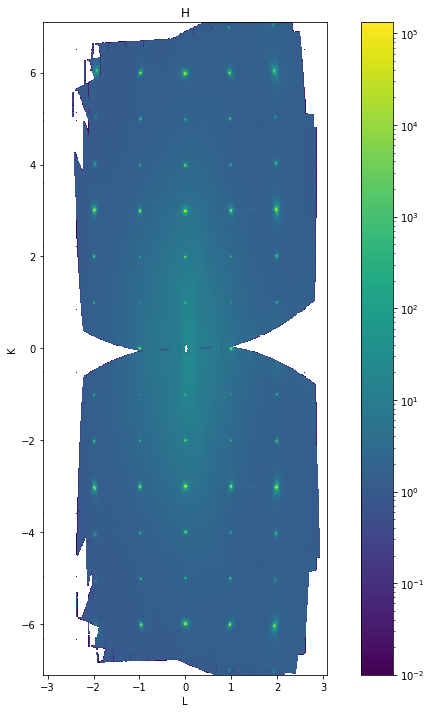

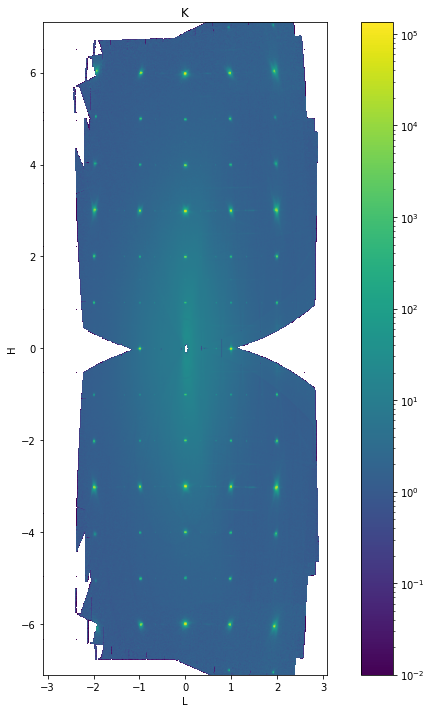

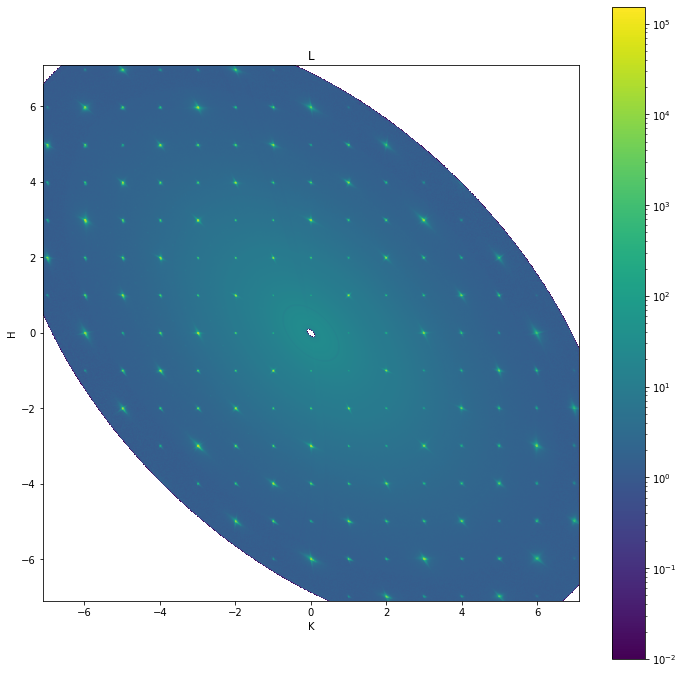

In [23]:
# retrieving OpenVisus dataset from the signal
idx_filename=eval(signal.attrs["openvisus"])[0]
db=ov.LoadDataset(idx_filename)

# this is the way we query the streamable data
ShowSlice(0,db.read(x=[X1,X2  ], y=[Y1,Y2  ],z=[MZ,MZ+1], num_refinements=1, quality=0)[0,:,:])
ShowSlice(1,db.read(x=[X1,X2  ], y=[MY,MY+1],z=[Z1,Z2  ], num_refinements=1, quality=0)[:,0,:])
ShowSlice(2,db.read(x=[MX,MX+1], y=[Y1,Y2  ],z=[Z1,Z2  ], num_refinements=1, quality=0)[:,:,0])

# Show coarse to fine

data ready float32 (1, 710, 155)


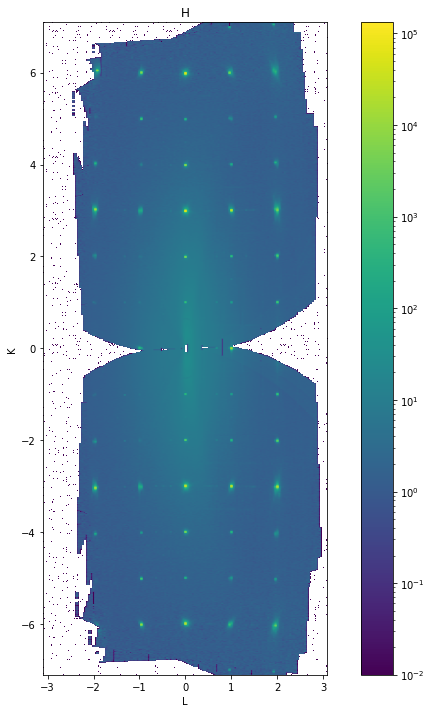

data ready float32 (1, 1420, 310)


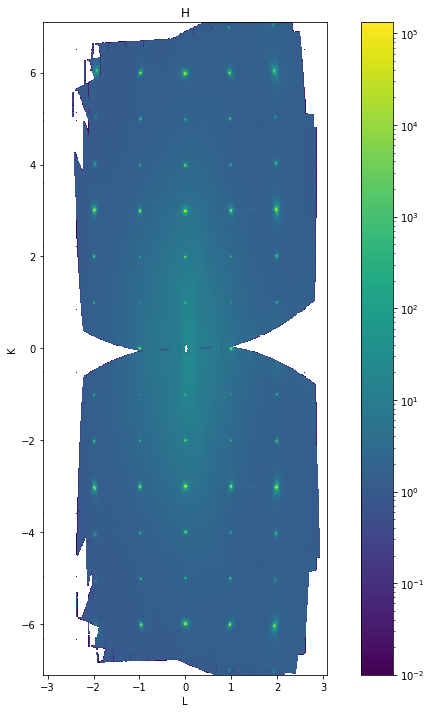

In [24]:
import os,sys
for vol in db.read(x=[X1,X2],y=[Y1,Y2],z=[MZ,MZ+1], num_refinements=3, quality=0):
	print("data ready",vol.dtype,vol.shape)
	ShowSlice(0 ,vol[0,:,:])

# Get from OpenVisus server

You need to 

- add the dataset to the `/nfs/chess/nsdf01/openvisus/lib64/python3.6/site-packages/OpenVisus/visus.config`
- launch the Open Visus server


if you want to enable dynmamic dataset  you can do for example:

```
<visus> 

<Configuration> 
    <ModVisus> 
      <Dynamic enabled="true"  filename="/nfs/chess/nsdf01/openvisus/lib64/python3.6/site-packages/OpenVisus/visus.config" msec="10000" /> 
    </ModVisus>
</Configuration>

<datasets>
    <dataset 
       name='recon_combined_1_fullres-arco-1mb' 
       url='/mnt/data1/nsdf/visus-datasets/chess/recon_combined_1_fullres/arco/1mb/zip/visus.idx'  />
</datasets>

</visus>
```

In [ ]:
def GetExportsFromScript(filename):
	ret={}
	with open(filename,"rt") as file:
		for v in [line.split() for line in file.readlines()]:
			if len(v)==2 and v[0].lower()=="export":
				v=v[1].split("=",1)
				if len(v)==2: ret[v[0].strip()]=v[1].strip()
	return ret

# Get credentials to access the OpenVisus server
exports=GetExportsFromScript("../../mod_visus.identity.sh")
db=ov.LoadDataset(f"https://nsdf01.classe.cornell.edu/mod_visus?dataset=3scans_HKLI&~auth_username={exports['MODVISUS_USERNAME']}&~auth_password={exports['MODVISUS_PASSWORD']}")
vol=db.read(x=[X1,X2],y=[Y1,Y2],z=[MZ,MZ+1], num_refinements=1, quality=0)
slice=vol[0,:,:]
print("data ready")
ShowSlice(0,slice)